In [142]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
import wntr
from pathlib import Path
import wntr.network.controls as controls
from dreaminsg_integrated_model.network_sim_models.interdependencies import *
from dreaminsg_integrated_model.data.disruptive_scenarios.disrupt_generator_discrete import *
import pandapower as pp

import math

In [144]:
network_dir= 'in2'

MAIN_DIR = Path('..')
#water_file = MAIN_DIR/'dreaminsg_integrated_model/data/networks/examples/water/networks/Net1.inp'
water_file = MAIN_DIR/'dreaminsg_integrated_model/data/networks/{}/water/Example_water2.inp'.format(network_dir)

step_size = 60
try:
    wn = wntr.network.WaterNetworkModel(water_file)
    wn.options.time.duration = step_size
    wn.options.time.report_timestep = step_size
    wn.options.time.hydraulic_timestep = step_size
    wn.options.hydraulic.demand_model = 'PDA'
    total_base_water_demand = sum([wn.get_node(node).base_demand for node in wn.junction_name_list])
    print("Water network successfully loaded.")
except FileNotFoundError:
    print("Error: The water network file does not exist. No such file or directory: ", water_file)

#interval_list = [step_size*70*i for i in range(1,10)]
interval_list = [3000, 480, 6240, 9720, 9720, 9720, 9720.0, 9720, 9720, 9720, 9720, 2340, 120, 120]
#interval_list = 14*[60]
print(interval_list)

W_P22_perf = [100, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 100, 100]
W_P22_state = ['N', "D", 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'R', 'R', 'SR', 'SR']
# W_WP9_perf = [100, 25, 25, 25, 25, 25, 25, 100]

W_WP9_perf = [100, 100, 100, 100, 25, 25, 25, 25, 25, 100, 100, 100, 100, 100, 100]

total_demand = []
component_pipe = "W_P22"
component_pump = "W_WP9"

water_consump_tracker =  []

Water network successfully loaded.
[3000, 480, 6240, 9720, 9720, 9720, 9720.0, 9720, 9720, 9720, 9720, 2340, 120, 120]


In [145]:
#leak node generation
wn = wntr.morph.split_pipe(
    wn, component_pipe, f"{component_pipe}_B", f"{component_pipe}_leak_node"
)
leak_node = wn.get_node(f"{component_pipe}_leak_node")

#simulation
for i in range(0,14):
    print(wn.control_name_list)
    print("Current time_step: ", wn.options.time.duration, "; Next tiem step: ", wn.options.time.duration + interval_list[i])
    print(i, "Pump performance: ", W_WP9_perf[i], "; Pipe performnace: ", W_P22_perf[i], "; Pipe state: ", W_P22_state[i])
    
    #leak scheduling
    if W_P22_perf[i] < 100 and W_P22_state[i] == "D":
        leak_node.remove_leak(wn)
        leak_node.add_leak(
            wn,
            area=0.005*(100 - W_P22_perf[i])
            * (math.pi * (wn.get_link(f"{component_pipe}_B").diameter) ** 2)
            / 4,
            start_time=wn.options.time.duration,
            end_time=wn.options.time.duration + interval_list[i],
        )
        print(f"The pipe leak is scheduled between {wn.options.time.duration} s and {wn.options.time.duration + interval_list[i]} s")
    elif (W_P22_perf[i] < 100) & (W_P22_state[i] == 'R'):
        wn.get_link(f"{component_pipe}_B").status = 0
    elif W_P22_perf[i] == 100:
        wn.get_link(f"{component_pipe}_B").status = 1
    
    #pump failure scheduling
    if W_WP9_perf[i] < 100:
        wn.get_link(component_pump).add_outage(
            wn, 
            wn.options.time.duration, 
            wn.options.time.duration + interval_list[i])
    # else:
    #     wn.get_link(component_pump).status = 1
        

    print("Simulation time: ", wn.options.time.duration,"; Hydraulic time step: ", wn.options.time.hydraulic_timestep, "; Report time step: ", wn.options.time.report_timestep)
    wn_sim = wntr.sim.WNTRSimulator(wn)
    wn_results = wn_sim.run_sim(convergence_error=True, solver_options = {'MAXITER': 5000})

    wn.options.time.duration += interval_list[i]
    wn.options.time.report_timestep += interval_list[i]
    #print("Performance of 'W_P22' is", W_P22_perf[i])
    #print("Performance of 'W_WP9' is", W_WP9_perf[i])
    #print(wn.link_name_list)
    print(wn_results.link['status'])
    print(wn_results.link['flowrate'])
    print(wn_results.node['leak_demand'])
    
    
    print("Pump: ", "\t\tstatus = ", wn_results.link['status']['W_WP9'].values, "\tflowrate = ", wn_results.link['flowrate']['W_WP9'].values)
    print("Tank: ", "\t\tdemand", wn_results.node['demand']['W_T2'].values, "\thead = ", wn_results.node['head']['W_T2'].values)
    print("Pipe from Tank: ", "status", wn_results.link['status']['W_P110'].values, "\tflowrate = ", wn_results.link['flowrate']['W_P110'].values)
    print("******************\n")

    water_consump_tracker.append(
            sum(
                [
                    list(wn_results.node["demand"][node])[0]
                    for node in wn.junction_name_list
                ]
            )
        )

['control 1', 'control 2']
Current time_step:  60.0 ; Next tiem step:  3060.0
0 Pump performance:  100 ; Pipe performnace:  100 ; Pipe state:  N
Simulation time:  60.0 ; Hydraulic time step:  60.0 ; Report time step:  60
    W_P10  W_P11  W_P12  W_P21  W_P22  W_P31  W_P110  W_P111  W_P112  W_P113  \
0       1      1      1      1      1      1       1       1       1       1   
60      1      1      1      1      1      1       1       1       1       1   

    W_P121  W_P122  W_P22_B  W_WP9  
0        1       1        1      1  
60       1       1        1      1  
       W_P10     W_P11     W_P12     W_P21     W_P22     W_P31    W_P110  \
0   0.145596  0.099537  0.006971  0.017592  0.008801  0.003232 -0.076197   
60  0.145560  0.099509  0.006973  0.017585  0.008800  0.003231 -0.076161   

      W_P111    W_P112    W_P113    W_P121    W_P122   W_P22_B     W_WP9  
0   0.036596  0.006905  0.000662  0.009541  0.003077  0.008801  0.145596  
60  0.036588  0.006912  0.000664  0.009540  0.00

<AxesSubplot:>

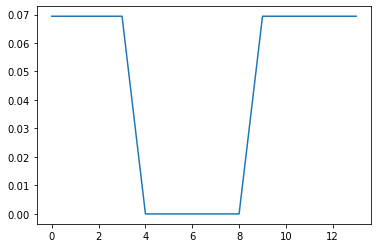

In [146]:
pd.Series(water_consump_tracker).plot()

In [147]:
wn.control_name_list

['control 1',
 'control 2',
 'W_WP9_power_off_19500.0',
 'W_WP9_power_on_29220.0',
 'W_WP9_power_off_29220.0',
 'W_WP9_power_on_38940.0',
 'W_WP9_power_off_38940.0',
 'W_WP9_power_on_48660.0',
 'W_WP9_power_off_48660.0',
 'W_WP9_power_on_58380.0',
 'W_WP9_power_off_58380.0',
 'W_WP9_power_on_68100.0',
 'junctionW_P22_leak_nodestart_leak_control',
 'junctionW_P22_leak_nodeend_leak_control']